# Time Series Prediction on Old Faithful

This is a small project investigating whether there is any pattern in the eruption
times of old faithful. The dataset is relatively small (only 273 examples), so we
have to be careful not to overfit the model to the data.

The first step is to load the data and plot the distribution of waiting times.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.warnings.filterwarnings('ignore')

df = pd.read_csv('../input/faithful.csv', index_col=[0])
df.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


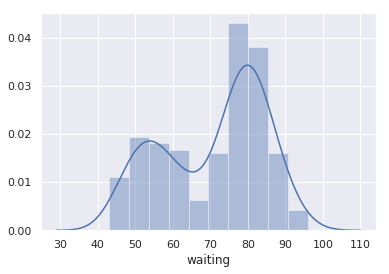

In [73]:
sns.distplot(df.waiting, bins=10);

This is hopeful. There are two major features of the distribution that I can see:

1. It is distinctly non-exponential (suggesting a driving cause that is cyclic in nature).
2. It is bi-modal (two humps).

Feature (1) is interesting, but it is feature (2) that causes me to wonder if there is a
pattern in the behavior of the geyser. For example, perhaps when it is in the "faster" mode
it tends to stay in that state for a cycle or two before switching to the "slower" mode. Or,
maybe it alternates between the two. Let's start by seeing if there is a correlation in time
between the cycles using the Kendall rank correlation test.

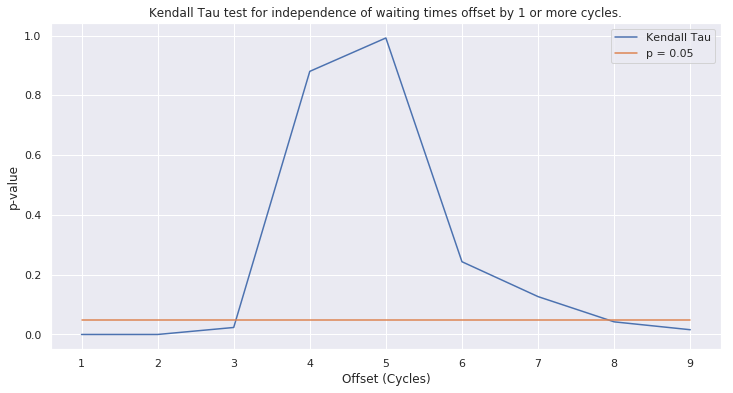

In [74]:
from scipy.stats import kendalltau
def offset(k):
    return df.waiting.iloc[:-k], df.waiting.iloc[k:]

def kendalltau_df(offsets, pval):
    pvals = [kendalltau(*offset(i)).pvalue for i in offsets]
    df = pd.DataFrame({'Offset (cycles)': offsets})
    df1,df2 = df.copy(),df.copy()
    df1['p-value'] = pvals
    df1[''] = 'Kendall Tau'
    df2['p-value'] = 0.05
    df2[''] = 'p = {}'.format(pval)
    return pd.concat([df1,df2])

    
offsets = np.arange(1,10)
plt.figure(figsize=[12, 6])
sns.lineplot(data=kendalltau_df(offsets, 0.05), x='Offset (cycles)', y='p-value', hue='')
plt.xlabel('Offset (Cycles)')
plt.ylabel('p-value');
plt.title('Kendall Tau test for independence of waiting times offset by 1 or more cycles.');

According to this test, the waiting times are not independent for up to 3 cycles (at the significance level of 0.05).

To look at this from a different angle, I'm going to use my Electrical Engineering background in communications. Let's pretend
Old Faithful is sending messages to the other geysers in Yellowstone encoded in binary and modulating the waiting time between
two values (fast and slow). In other words, the waiting times encode a long binary string.

What we want to do is build a predictor telling us how long we need to wait for the next eruption, given a sequence of previous
eruptions. Interestingly, this is highly related to compressing a binary string. A highly compressible string (meaning it has a
lot of redundancy) is easy to predict. Of course, sometimes you have to be clever to discover that redundancy, but maybe we'll
be lucky in this case.

First, let's convert the cycle times into a binary string. To my eye, the slow and fast times can be sufficiently divided by a
threshold of 67 seconds&mdash;a rough maximum a posteriori (MAP) estimate.

In [75]:
code = (df.waiting > 67).values.astype(int)
print(''.join(code.astype(str)))

10101011010110100101001111011111011001011010110010110101101101010111011011010111111011110101010111010101101011101101010101101101010101010101101110101011011111010101010101001111101101110110101011111101011010110111010101010101111111101010011010101101010111111101110100110101


Now, let's compute the entropy of subsequences of this string. The entropy gives the minimum number of bits per subsequence
attainable by a compression algorithm. We'll normalize this by the number of bits per subsequence for a fair comparison. In addition,
it's good to check the results with a purely random sequence with the same 0/1 probabilities (a sequence of Bernoulli random variables).

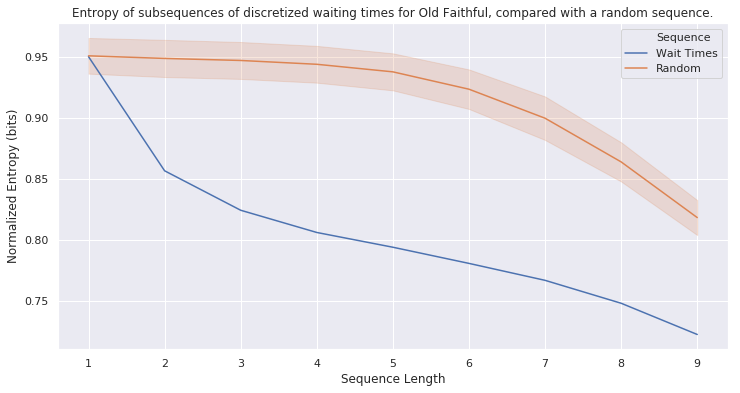

In [76]:
def code_set(code, n):
    return pd.Series(list(code[(np.arange(len(code)-n)[:,None] + np.arange(n)).ravel()].reshape(-1,n).astype(str))).str.join('')

def entropy(code_set):
    from scipy.stats import entropy as h
    return h(code_set.value_counts().values, base=2)

def entropy_df(title, *codes):
    offsets = np.arange(1,10)
    ents = np.array([[entropy(code_set(c, i))/i for i in offsets] for c in codes])
    df = pd.DataFrame({'Sequence Length': offsets[None,:][[0]*len(codes)].flatten(), 'Normalized Entropy (bits)':ents.flatten()})
    df['Sequence'] = title
    return df
    
def fake_code(code):
    from scipy.stats import bernoulli as ber
    return ber.rvs(code.mean(), size=len(code))

plt.figure(figsize=[12,6])
edf = pd.concat([entropy_df('Wait Times', code), entropy_df('Random', *[fake_code(code) for _ in range(15)])])
sns.lineplot(data=edf, x='Sequence Length', y='Normalized Entropy (bits)', hue='Sequence', ci='sd')
plt.title('Entropy of subsequences of discretized waiting times for Old Faithful, compared with a random sequence.');

Aha! The entropy of the sequence goes down signficantly faster than the random control as we consider larger and larger subsequences.
Once the sequence length reaches about 9, this analysjis doesn't really work (as we do not have sufficient data). But there is a
clear reduction in entropy up to about length 4. Let's look at the value counts for this.

In [77]:
code_set(code, 4).value_counts().to_frame().rename({0:'count'}, axis=1)

,count
1010,50
0101,47
1101,37
1011,35
0110,23
1111,23
1110,16
0111,16
1001,7
0100,5


Ok, that checks matches what the analysis turned up already. This indicates that we can make a pretty decent predictor by looking at the previous three cycle times. Let's investigate this.

In [78]:
def marginals(code, n):
    vc = code_set(code, n).value_counts().to_frame().reset_index()
    vc['prefix'], vc['suffix'] = vc['index'].str.slice(0,3), vc['index'].str.slice(3,4)
    vc = vc.set_index(['prefix', 'suffix'])[0].unstack('suffix').fillna(0)
    vc['prob'] = vc.sum(axis=1)
    vc[['0','1']] = vc[['0','1']].div(vc.prob, axis=0)
    vc.prob /= vc.prob.sum()
    return vc.sort_values('prob', ascending=False)

def accuracy(marg):
    return (marg[['0','1']].max(axis=1)*marg.prob).sum()
    
m = marginals(code, 4)
print("Accuracy: {:0.2f}".format(accuracy(m)))
print("Random Guessing: {:0.2f} ± {:0.2f}".format(code.mean(), code.std()/np.sqrt(len(code))))
m

Accuracy: 0.71
Random Guessing: 0.63 ± 0.03


suffix,0,1,prob
prefix,,,
101,0.588235,0.411765,0.317164
010,0.096154,0.903846,0.194030
011,0.589744,0.410256,0.145522
110,0.051282,0.948718,0.145522
111,0.410256,0.589744,0.145522
001,0.428571,0.571429,0.026119
100,0.000000,1.000000,0.026119


Ok, this method has a slight (but statistically significant) improvement over randomly guessing the more prominent class "1" (the slower waiting time). Let's try a building simple linear model directly on the waiting time (instead of the binary string) and see how well it does.

In [79]:
from sklearn.linear_model import LinearRegression

wait = df.waiting.values
times = wait[np.arange(len(wait)-4)[:,None] + np.arange(4)].reshape(-1,4)
X = times[:,:3]
y = times[:,3]

reg = LinearRegression()
reg.fit(X,y)
qs = [0,0.1,0.33,0.5,0.66,0.9,1.0]
te = pd.DataFrame(np.abs(reg.predict(X)-y), columns=['true_error']).quantile(qs)
rd = pd.DataFrame(np.abs((wait[:,None]-wait).flatten()), columns=['rand_error']).quantile(qs)
pd.concat([te,rd], axis=1)

,true_error,rand_error
0.00,0.013857,0.0
0.10,1.639394,2.0
0.33,5.045880,7.0
0.50,8.520909,13.0
0.66,11.760510,21.0
0.90,18.213166,32.0
1.00,34.677696,53.0


Nice! Seems that we are still doing marginally better than random guessing. To really know for sure we need more data over a longer period of time. I'm afraid that if you are interested in predicting Old Faithful eruptions you will have to go and find this data yourself. However, this notebook demonstrates that there is at least a hope in predicting the phenomenon, and if you can figure out how to predict it you are on your way to understanding it.